here I'm using a custom [scallop](https://github.com/Kingsford-Group/scallop) + [gtfmerge](https://github.com/Kingsford-Group/rnaseqtools#gtfmerge) pipeline to create merged gtf annotation of hg19 and tinat transcripts introduced in this 

Alex
> I was curious myself so I decided to align our RNA-seq data to their chimeric transcripts... it looks promising, but let me know if there's anything in my analysis I need to change. Still working on seeing if we can identify alternative TSS without CAGE-seq. 
I'm guessing we can look for novel transcripts using [StringTie](https://ccb.jhu.edu/software/stringtie/) or cufflinks?

Ray
> I'm asking because in [this paper](https://www.nature.com/articles/ng.3889) they treated lung cancer cells with decitabine and performed Cage-seq to map and identify cryptic transcription start sites. They found cryptic TSSs that generated spliced variants, half of which were in-frame isoforms (and some of which resulted in chimeric transcripts, others original or truncated). This got me thinking about our project and whether we could see these chimeric/fusion transcripts (that are skewed toward the 5'end due Cage-seq and being TSS-induced) in HL60s.  


Luke
> Hi Ray, Alex and Abe
This is an interesting paper which claims genetic alterations to DNA methylation core genes drive dysregulated hematopoietic development due to CpG changes that regulate transcription factor binding (figure 4 and 5). How many TFs are methylation sensitive has been controversial in my understanding but is an interesting idea with lots of data within mylomonocytic cells. https://www.nature.com/articles/s41588-020-0595-4
I am not suggesting a specific plan but this is an interesting idea.


In [3]:
cat scallop/tinat/tinat-gtf-list.txt

hg19/hg19.knownGene.gtf
tinat/DAC+SB_TINATs.gtf
tinat/DAC_TINATs.gtf
tinat/SB939_TINATs.gtf



In [4]:
cat scallop/tinat.sh

mkdir -p scallop/tinat/compare

PATH=$PATH:/rumi/shams/abe/Workflows/rnaseqtools-1.0.3/bin/

conda activate scallop
# 1. merge
gtfmerge union scallop/tinat/tinat-gtf-list.txt scallop/tinat/hg19.tinat.gtf -t 18
# 2. compare 
gffcompare -o scallop/tinat/gffall -r /rumi/shams/genomes/hg19/hg19_genes.gtf scallop/tinat/hg19.tinat.gtf 
# 3. subset
gtfcuff puniq scallop/tinat/gffall.hg19.tinat.gtf.tmap scallop/tinat/hg19.tinat.gtf /rumi/shams/genomes/hg19/hg19_genes.gtf scallop/tinat/unique.gtf
# 4. gtf2fasta
gffread scallop/tinat/unique.gtf -g /rumi/shams/genomes/hg19/hg19.fa -w scallop/tinat/unique.fa
# 5.concatenate with hg19 fasta
# mkdir -p scallop/hg19
# wget https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/genes/hg19.knownGene.gtf.gz
# mv hg19.knownGene.gtf.gz scallop/hg19/hg19.knownGene.gtf.gz
# gunzip scallop/hg19/hg19.knownGene.gtf.gz
gffread scallop/hg19/hg19.knownGene.gtf -g /rumi/shams/genomes/hg19/hg19.fa -w scallop/hg19/hg19.knownGene.fa
cat scallop/hg19/hg19.knownGene.f

# R

In [1]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library (GenomicFeatures)
library (tximport)
library (tidyverse)
library (ggplot2)
library (ggrepel)
library (DESeq2)
library (patchwork)
library (BiocParallel)
register(MulticoreParam(18))

plot_Save <- function (p, name_it){
    ggsave(paste(name_it,'png',sep='.'), plot = p, device = 'png', dpi = 300)
    ggsave(paste(name_it,'pdf',sep='.'), plot = p, device = 'pdf', dpi = 300)
}

### Load genome annotations 

In [4]:
%%R 
txdb.hg19  = makeTxDbFromGFF('scallop/hg19/hg19.knownGene.gtf', organism='Homo sapiens')

tin_1 <- rtracklayer::import('scallop/tinat/DAC+SB_TINATs.gtf')%>% data.frame %>% filter(type == "transcript") %>% dplyr::select('gene_id','transcript_id')
tin_2 <- rtracklayer::import('scallop/tinat/DAC_TINATs.gtf')   %>% data.frame %>% filter(type == "transcript") %>% dplyr::select('gene_id','transcript_id')
tin_3 <- rtracklayer::import('scallop/tinat/SB939_TINATs.gtf') %>% data.frame %>% filter(type == "transcript") %>% dplyr::select('gene_id','transcript_id')
tins <- rbind(tin_1, tin_2,tin_3) 
colnames(tins) <- c("GENEID", "TXNAME")
# tx2gene objects 
k.hg19 <- keys(txdb.hg19, keytype = "TXNAME")
tx2gene.hg19 <- AnnotationDbi::select(txdb.hg19, k.hg19, "GENEID", "TXNAME")

tx2gene = rbind(tx2gene.hg19, tins)

R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK

R[write to console]: 'select()' returned 1:1 mapping between keys and columns



In [5]:
%%R
c(tin_1 %>% nrow, tin_2 %>% nrow, tin_3 %>% nrow)

[1] 3627  453  744


In [6]:
%%bash 
# cat scallop/tinat/tinat-gtf-list.txt
wc -l scallop/tinat/DAC+SB_TINATs.gtf
wc -l scallop/tinat/DAC_TINATs.gtf
wc -l scallop/tinat/SB939_TINATs.gtf

12172 scallop/tinat/DAC+SB_TINATs.gtf
1403 scallop/tinat/DAC_TINATs.gtf
2059 scallop/tinat/SB939_TINATs.gtf


In [7]:
%%R
tx2gene %>% nrow

[1] 87784


In [8]:
%%R
tx2gene.hg19 %>% nrow

[1] 82960


In [9]:
%%R
tins %>% nrow 

[1] 4824


Read salmon quants 

In [10]:
%%R
files <- list.files(path='./scallop/hg19.tinat_quants', pattern="quant.sf",full.names = TRUE, recursive=T)
names(files) <- gsub("./scallop/hg19.tinat_quants/(\\S+)/quant.sf","\\1",files)

txi <- tximport(files, type = "salmon", tx2gene = tx2gene, txOut=T)

R[write to console]: reading in files with read_tsv

R[write to console]: 1 
R[write to console]: 2 
R[write to console]: 3 
R[write to console]: 4 
R[write to console]: 5 
R[write to console]: 6 
R[write to console]: 7 
R[write to console]: 8 
R[write to console]: 9 
R[write to console]: 10 
R[write to console]: 11 
R[write to console]: 12 
R[write to console]: 



In [11]:
# %%R
# txi.gene <- summarizeToGene(txi, tx2gene, ignoreAfterBar= TRUE)

Define the sample sheet 

In [12]:
%%R 
# meta 
treats  <- rep(c(rep('DMSO',2), rep('treated',2)),3)
reps    <- rep(c('rep1','rep2'),6)
hours   <- c(rep('120h',4),rep('6h',4),rep('72h',4))
colData <- data.frame(
    time=hours, 
    cond=treats, 
    sample_id=paste(hours, treats, reps, sep='_'),
    row.names=colnames(txi$abundance))
colData

                  time    cond         sample_id
120h_DMSO_rep1    120h    DMSO    120h_DMSO_rep1
120h_DMSO_rep2    120h    DMSO    120h_DMSO_rep2
120h_treated_rep1 120h treated 120h_treated_rep1
120h_treated_rep2 120h treated 120h_treated_rep2
6h_DMSO_rep1        6h    DMSO      6h_DMSO_rep1
6h_DMSO_rep2        6h    DMSO      6h_DMSO_rep2
6h_treated_rep1     6h treated   6h_treated_rep1
6h_treated_rep2     6h treated   6h_treated_rep2
72h_DMSO_rep1      72h    DMSO     72h_DMSO_rep1
72h_DMSO_rep2      72h    DMSO     72h_DMSO_rep2
72h_treated_rep1   72h treated  72h_treated_rep1
72h_treated_rep2   72h treated  72h_treated_rep2


# Differential expression analysis

In [13]:
%%R
plot_Volcano <- function(res, lfc.cutoff  = 1,pval.cutoff = 0.05, title='', x_min=-20,x_max=20){
    res$sig <- as.factor(res$pvalue < pval.cutoff & abs(res$log2FoldChange) > lfc.cutoff)
    relevel(res$sig, ref=TRUE)
    vol = res %>% ggplot(
        aes(x=log2FoldChange, y=-log10(pvalue), colour=sig, fill=sig)) +
        geom_point(aes(color = sig),alpha = 1/10) +
            xlim(c(x_min,x_max)) +
    #         ylim(c(0,11)) +
            geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "red")) +
            theme_bw() + 
            theme(legend.position="none") +
            ggtitle (title) + 
            geom_text_repel(
                data = subset(res[order(res$pvalue),], sig == TRUE)[1:7,],
                aes(label = name),
                size = 3,
                box.padding = unit(0.35, "lines"),
                point.padding = unit(0.3, "lines")
            )
     return (vol)
} 

get_Result <- function(dds, design){
    res = results(dds, contrast=design, parallel=TRUE)  %>% data.frame  %>% add_column(name=rownames(dds))
    res$log2FoldChange[is.na(res$log2FoldChange)] <- 0
    res$padj[is.na(res$padj)] <- 1
    return (res)
}

write_Result <- function(res, name_it, col=FALSE, row=FALSE){
    write.table(res,name_it, sep="\t", quote=FALSE, col.names=col, row.names=row)
}

In [14]:
%%R 
dds <- DESeqDataSetFromTximport(txi, colData, ~cond + time + cond:time)

dds$time <- relevel(dds$time, ref="6h")

# Annova
dds <- DESeq(dds, test="LRT", reduced=~1, parallel=TRUE)
ncu <- counts(dds, normalized=TRUE) 
write.table(ncu,'scallop/DE2norm.txt', sep="\t", quote=FALSE, col.names=colData$sample_id)

R[write to console]: using counts and average transcript lengths from tximport

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates: 18 workers

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates, fitting model and testing: 18 workers



In [15]:
%%R
resultsNames(dds)

[1] "Intercept"            "cond_treated_vs_DMSO" "time_120h_vs_6h"     
[4] "time_72h_vs_6h"       "condtreated.time120h" "condtreated.time72h" 


In [16]:
%%R
dds_ind <- DESeqDataSetFromTximport(txi, colData, ~cond + time)
dds_ind$time <- relevel(dds_ind$time, ref="6h")

dds_ind <- DESeq(dds_ind, test="LRT", reduced=~1, parallel=TRUE)

R[write to console]: using counts and average transcript lengths from tximport

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates: 18 workers

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates, fitting model and testing: 18 workers



In [17]:
%%R
counts(dds_ind) %>% dim 

[1] 35932    12


In [34]:
%%R
# no interaction
res.ind = get_Result(dds_ind,list('cond_treated_vs_DMSO'))

# contrast design: treatment at 6h vs dmso at 6h
res.6h  = get_Result(dds, list('cond_treated_vs_DMSO'))
res.6h  [res.6h$padj   > 0.05,] = res.ind[res.6h$padj  > 0.05,]

# contrast design: treatment at 72h vs dmso at 72h
res.72h = get_Result(dds, list('cond_treated_vs_DMSO', 'condtreated.time72h'))
res.72h [res.72h$padj  > 0.05,] = res.ind[res.72h$padj > 0.05,]

# contrast design: treatment at 120h vs dmso at 120h
res.120h= get_Result(dds, list('cond_treated_vs_DMSO', 'condtreated.time120h'))
res.120h[res.120h$padj > 0.05,] = res.ind[res.120h$padj> 0.05,]

res.ind  = res.ind [!rownames(res.ind) %in% tx2gene.hg19$TXNAME,] 
res.6h   = res.6h  [!rownames(res.6h)  %in% tx2gene.hg19$TXNAME,] 
res.72h  = res.72h [!rownames(res.72h) %in% tx2gene.hg19$TXNAME,] 
res.120h = res.120h[!rownames(res.120h)%in% tx2gene.hg19$TXNAME,] 

In [35]:
%%R    
df = data.frame(
    'gene_id'=rownames(res.ind), 
    'baseMean' = res.ind$baseMean,
    'log2FC_6h' = res.6h$log2FoldChange,'pval_6h'= res.6h$pval,
    'log2FC_72h' = res.72h$log2FoldChange,'pval_72h'= res.72h$pval,
    'log2FC_120h'  = res.120h$log2FoldChange,'pval_120h'= res.120h$pval)
    
df = df[order(df$log2FC_120h),]
    
write_Result(df, 'scallop/results_time_factor.txt', col=TRUE)

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



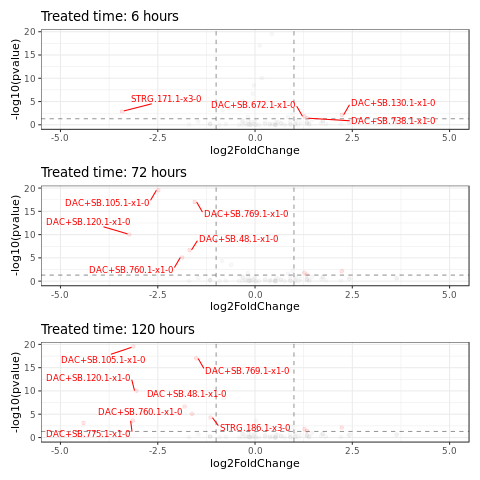

In [36]:
%%R
vol.6h  = plot_Volcano(res.6h[tins$GENEID,], title='Treated time: 6 hours',x_min=-5,x_max=5)
vol.72h = plot_Volcano(res.72h[tins$GENEID,], title='Treated time: 72 hours',x_min=-5,x_max=5)
vol.120h= plot_Volcano(res.120h[tins$GENEID,], title='Treated time: 120 hours',x_min=-5,x_max=5)

vol = vol.6h / vol.72h / vol.120h
plot_Save(vol, 'scallop/Volcano_time_factor')
vol

### Second scenario
Time as continues variable

In [2]:
# %%R 
# # meta 
# colData.T <- data.frame(
#     time=c(rep(120,4),rep(6,4),rep(72,4)), 
#     cond=rep(c(rep('DMSO',2), rep('treated',2)),3), 
#     time_cond=paste(hours,treats,sep='_'), 
#     sample_id=colnames(txi$abundance),
#     row.names=colnames(txi$abundance))

# dds.T <- DESeqDataSetFromTximport(txi, colData.T, ~cond + time + cond:time)
# dds.T <- DESeq(dds.T, test="LRT", reduced=~1, parallel=TRUE)

In [3]:
# %%R
# resultsNames(dds.T)

In [4]:
# %%R
# res_cnt_time_T_vs_U = results(dds.T, name='cond_treated_vs_DMSO', parallel = TRUE) %>% 
#     data.frame %>% add_column(name = rownames(dds.T))
# res_cnt_time_T_vs_U$log2FoldChange[is.na(res_cnt_time_T_vs_U$log2FoldChange)] <- 0
# res_cnt_time_T_vs_U$padj[is.na(res_cnt_time_T_vs_U$padj)] <- 1

# res_cnt_time = results(dds.T, name='condtreated.time', parallel=TRUE) %>% 
#     data.frame %>% add_column(name = rownames(dds.T))
# res_cnt_time$log2FoldChange[is.na(res_cnt_time$log2FoldChange)] <- 0
# res_cnt_time$padj[is.na(res_cnt_time$padj)] <- 1

# res_cnt_time_T_vs_U  = res_cnt_time_T_vs_U [!rownames(res_cnt_time_T_vs_U) %in% tx2gene.hg19$TXNAME,] 
# res_cnt_time  = res_cnt_time [!rownames(res_cnt_time) %in% tx2gene.hg19$TXNAME,] 

In [5]:
# %%R
# p1 = plot_Volcano(res_cnt_time_T_vs_U, 0.1, title='Time as continuous variable: Treated vs DMSO', 
#                   x_min=-2,x_max=2)
# p2 = plot_Volcano(res_cnt_time, 0.01, title='Time as continuous variable: Condition and time interaction', 
#                   x_min=-0.1,x_max=0.1)

# plot_Save(p1 / p2, 'scallop/Volcano_time_continuous')

# p1 / p2

In [6]:
# %%R
# df = data.frame(
#     'gene_id'=rownames(res_cnt_time_T_vs_U), 'gene_name'= res_cnt_time_T_vs_U$name,
#     'baseMean' = res_cnt_time$baseMean,
#     'log2FC_time' = res_cnt_time$log2FoldChange,'log2FC_time'= res_cnt_time$pval,
#     'log2FC_T_vs_U' = res_cnt_time_T_vs_U$log2FoldChange,'pval_T_vs_U'= res_cnt_time_T_vs_U$pval
# )    
# df = df[order(df$log2FC_time),]

# write_Result(df, 'scallop/results_time_continuous.txt', col=TRUE)

In [21]:
%%R 
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/deseq/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] patchwork_1.0.0             DESeq2_1.20.0              
 [3] SummarizedExperiment_1.10.1 DelayedArray_0.6.6         
 [5] BiocParallel_1.14.2         matrixStats_0.55.0         
 [7] ggrepel_0.8.1               forcats_0.4.0              
 [9] stringr_1.4.0    